# initial work

In [1]:
import rampy as rp
import matplotlib.pyplot as plt
import pickle
import lmfit
from lmfit.models import LorentzianModel
from lmfit.models import PolynomialModel
import peakutils
import shoyu

In [2]:
# import data dict
shoyu_data_dict = pickle.load(open('raman_spectra/shoyu_data_dict.p', 'rb'))
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMALDEHYDE',
 'FORMIC ACID',
 'WATER']

In [3]:
data = shoyu_data_dict['CARBON DIOXIDE']

[(621.262686, 0.5349999999999999),
 (651.636613, 0.6970000000000001),
 (670.32826, 0.9308),
 (725.234974, 0.667),
 (2262.622963, 0.2815),
 (2281.31461, 0.33899999999999997),
 (2303.510942, 0.863),
 (2326.875501, 0.982),
 (3592.0663765, 0.3398),
 (3620.1038475, 0.38770000000000004),
 (3696.0386642500002, 0.41700000000000004),
 (3715.89854, 0.511)]

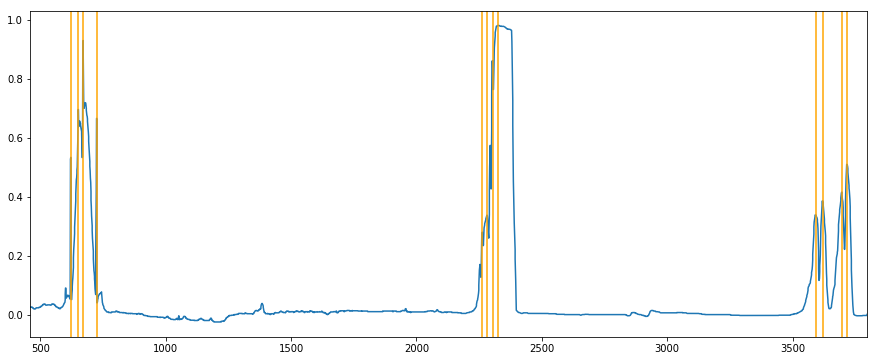

In [4]:
# extract data
x = data['x']
y = data['y']

indexes = peakutils.indexes(y, thres=0.3, min_dist=10)

plt.figure(figsize=(15,6))
plt.plot(x, y)
plt.xlim(min(x), max(x))
# plt.ylim(0, 1.05)

for i in indexes:
    peak_index = x[i]
    plt.axvline(x=peak_index, color='orange')
indexes

peaks = []
for i in indexes:
    peak = (x[i], y[i])
    peaks.append(peak)
peaks

In [5]:
# assign lorentzian parameters
peaks = peaks
peak_list = []
for i in range(len(peaks)):
    prefix = 'p{}_'.format(i+1)
    peak = LorentzianModel(prefix=prefix)
    if i == 0:
        pars = peak.make_params()
    else:
        pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks[i][0], vary=True, min=(peaks[i][0]-10), max=(peaks[i][0]+10))
    pars[prefix+'height'].set(peaks[i][1], vary=True, min=0, max=1)
    pars[prefix+'sigma'].set(min=0, max=500)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    if i == 0:
        mod = peak_list[i]
    else:
        mod = mod + peak_list[i]

In [6]:
# fit model
init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.5))

[[Model]]
    (((((((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_')) + Model(lorentzian, prefix='p9_')) + Model(lorentzian, prefix='p10_')) + Model(lorentzian, prefix='p11_')) + Model(lorentzian, prefix='p12_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8638
    # data points      = 3573
    # variables        = 48
    chi-square         = 8.75109926
    reduced chi-square = 0.00248258
    Akaike info crit   = -21384.8100
    Bayesian info crit = -21088.1143
[[Variables]]
    p1_sigma:       0.11099031 (init = 1)
    p1_center:      620.682058 (init = 621.2627)
    p1_amplitude:   4.09651851 (init = 1)
    p1_fwhm:        0.22198063 == '2.0000000*p1_sigma'
    p1_height:      0.53500000 (init = 0.535)
    p2_sigma:       1

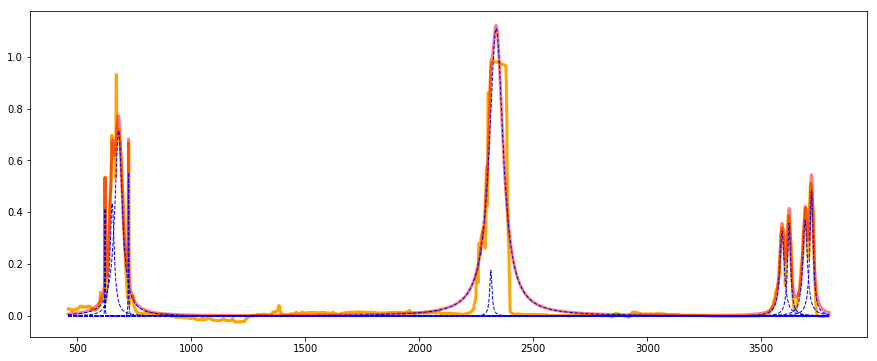

In [7]:
fig = plt.figure(figsize=(15,6))

# plt.plot(x, init, 'k--')
plt.plot(x, y, 'orange', alpha=1, linewidth=3)
plt.plot(x, out.best_fit, 'r-', alpha=0.5, linewidth=3)

plot_components = True
if plot_components:
    comps = out.eval_components(x=x)
    for i in range(len(peaks)):
        prefix = 'p{}_'.format(i+1) 
        plt.plot(x, comps[prefix], 'b--', linewidth=1)

plt.show()

# baseline

In [8]:
data = shoyu_data_dict['FORMIC ACID']

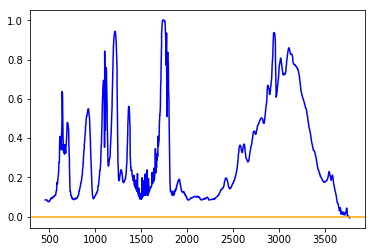

In [9]:
# extract data
x = data['x']
y = data['y']

plt.plot(x, y, 'b')
plt.axhline(y=0, color='orange')

In [10]:
from peakutils.baseline import baseline

In [11]:
yb = baseline(y, deg=3, max_it=200)
yb_plus = [0 if i < 0 else i for i in yb]

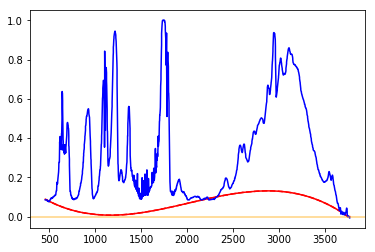

In [12]:
plt.plot(x, yb, 'r--')
plt.plot(x, yb_plus, 'r')
plt.plot(x, y, 'b')
plt.axhline(y=0, color='orange', alpha=0.5)

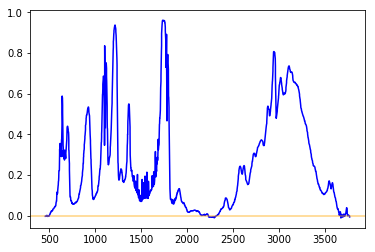

In [13]:
y2 = y-yb_plus
plt.plot(x, y2, 'b')
plt.axhline(y=0, color='orange', alpha=0.5)

In [47]:
from peakutils.baseline import baseline
import matplotlib.pyplot as plt


def subtract_baseline(y_data, deg=5, plot=False, x_data=None):
    """
    Function that fits a n-degree polynomial (default: n=5)
    baseline and subtracts it from the input data
    """
    y_base = baseline(y_data, deg=deg, max_it=200)
    # to avoid strange results,
    # change all negative values to zero
    yb_plus = [0 if i < 0 else i for i in y_base]
    y_out = y_data - yb_plus
    # plot that lets you see the baseline fitting
    if plot and x_data is None:
        print('Please add x_data as input to plot')
    elif plot:
        plt.figure(figsize=(10,4))
        plt.plot(x_data, y_data, 'b--', label='input')
        plt.plot(x_data, y_out, 'b', label='output')
        plt.plot(x_data, yb_plus, 'r', label='baseline')
        plt.plot(x_data, y_base, 'r--', label='negative baseline')
        plt.axhline(y=0, color='orange', alpha=0.5, label='zero') 
        plt.legend()
    else:
        pass
    return y_out

In [49]:
import numpy as np

def gaussian(x_input, var_a, var_b, var_c):
    y_output = var_a*np.exp(-((x_input-var_b)**2)/(2*(var_c**2)))
    return y_output

# generate test data
X_TEST = np.arange(500, 3500, 5)
# generate 6 gaussians
gauss1 = gaussian(X_TEST, 0.9, 2000, 100)
gauss2 = gaussian(X_TEST, 0.5, 1000, 200)
gauss3 = gaussian(X_TEST, 0.4, 2500, 1000)
gauss4 = gaussian(X_TEST, 0.7, 3200, 50)
gauss5 = gaussian(X_TEST, 0.7, 2200, 20)
gauss6 = gaussian(X_TEST, 0.7, 4000, 500)
# add gaussians to create fake spectra
Y_TEST = gauss1 + gauss2 + gauss3 + gauss4 + gauss5 + gauss6
# normalize test spectra
Y_TEST = [(Y_TEST[i] - min(Y_TEST))/(max(Y_TEST)-min(Y_TEST)) for i in range(len(Y_TEST))]
Y_TEST = np.asarray(Y_TEST)

def test_subtract_baseline():
    """docstring"""
    y_data = subtract_baseline(X_TEST, Y_TEST)
    assert isinstance(y_data, numpy.array), 'output is not a numpy array'
    assert len(y_data) == len(Y_TEST), 'output length different from input'

numpy.ndarray

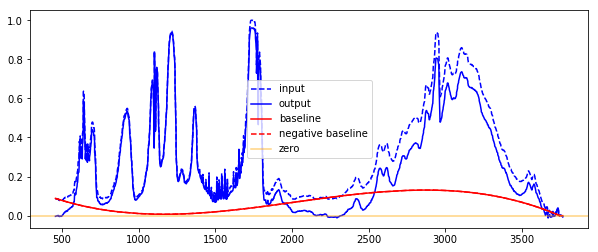

In [42]:
y_data = subtract_baseline(y, deg=3, plot=True, x_data=x)
type(Y_TEST)

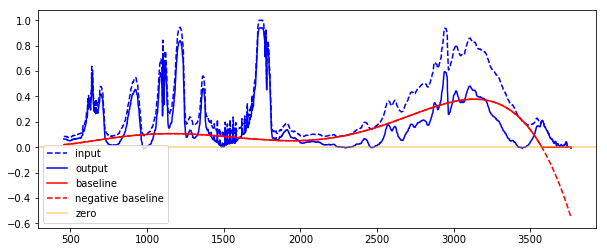

In [43]:
y_data = subtract_baseline(y, deg=5, plot=True, x_data=x)

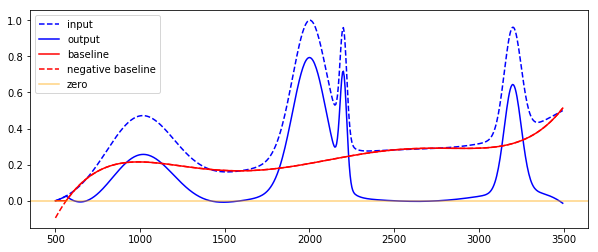

In [48]:
y_data = subtract_baseline(Y_TEST, deg=5, plot=True, x_data=X_TEST)

# identify and save peaks

In [54]:
data = shoyu_data_dict['CARBON DIOXIDE']
x_data = data['x']
y_data = data['y']

In [74]:
import peakutils

def find_peaks(x_data, y_data, thres=0.25, min_dist=10):
    """docstring"""
    # find peaks
    indexes = peakutils.indexes(y_data, thres=thres, min_dist=min_dist)
    # convert peak indexes to data values
    peaks = []
    for i in indexes:
        peak = (x_data[i], y_data[i])
        peaks.append(peak)
    peaks
    return peaks

In [77]:
peaks = find_peaks(X_TEST, Y_TEST)
peaks

[(1015, 0.47173450895943564),
 (2000, 1.0),
 (2200, 0.9592560646602497),
 (3200, 0.9613233783367838)]

In [79]:
def test_find_peaks():
    """docstring"""
    peaks = find_peaks(x_data, y_data)
    assert isinstance(peaks, list), 'expected output is list'
    assert isinstance(peaks[0], tuple), 'first peak data is not a tuple'
    assert min(x_data) <= peaks[0][0] <= max(x_data), '1st peak center is outside data range'
    assert 0 <= peaks[0][1] <= 1, '1st peak maximum is outside acceptable range'

# assign parameters for peaks

In [114]:
peaks = peaks

import lmfit
from lmfit.models import LorentzianModel

def lorentz_params(peaks):
    peak_list = []
    for i in range(len(peaks)):
        prefix = 'p{}_'.format(i+1)
        peak = LorentzianModel(prefix=prefix)
        if i == 0:
            pars = peak.make_params()
        else:
            pars.update(peak.make_params())
        pars[prefix+'center'].set(peaks[i][0], vary=True, min=(peaks[i][0]-10), max=(peaks[i][0]+10))
        pars[prefix+'height'].set(peaks[i][1], vary=True, min=0, max=1)
        pars[prefix+'sigma'].set(min=0, max=500)
        pars[prefix+'amplitude'].set(min=0)
        peak_list.append(peak)
        if i == 0:
            mod = peak_list[i]
        else:
            mod = mod + peak_list[i]
    return mod, pars

In [113]:
mod, pars = lorentz_params(peaks)
pars

Parameters([('p1_sigma', <Parameter 'p1_sigma', 1.0, bounds=[0:500]>),
            ('p1_center', <Parameter 'p1_center', 1015, bounds=[1005:1025]>),
            ('p1_amplitude', <Parameter 'p1_amplitude', 1.0, bounds=[0:inf]>),
            ('p1_fwhm',
             <Parameter 'p1_fwhm', 2.0, bounds=[-inf:inf], expr='2.0000000*p1_sigma'>),
            ('p1_height',
             <Parameter 'p1_height', 0.47173450895943564, bounds=[0:1]>),
            ('p2_sigma', <Parameter 'p2_sigma', 1.0, bounds=[0:500]>),
            ('p2_center', <Parameter 'p2_center', 2000, bounds=[1990:2010]>),
            ('p2_amplitude', <Parameter 'p2_amplitude', 1.0, bounds=[0:inf]>),
            ('p2_fwhm',
             <Parameter 'p2_fwhm', 2.0, bounds=[-inf:inf], expr='2.0000000*p2_sigma'>),
            ('p2_height', <Parameter 'p2_height', 1.0, bounds=[0:1]>),
            ('p3_sigma', <Parameter 'p3_sigma', 1.0, bounds=[0:500]>),
            ('p3_center', <Parameter 'p3_center', 2200, bounds=[2190:2210]>),


In [107]:
def test_lorentz_params():
    peaks = find_peaks(X_TEST, Y_TEST)
    mod, pars = lorentz_params(peaks)
    assert isinstance (mod, lmfit.model.CompositeModel), 'mod is not a lmfit CompositeModel'
    assert isinstance (pars, lmfit.parameter.Parameters), 'pars are not lmfit Parameters'
    assert len(pars) == 5*len(peaks), 'incorrect ratio of parameters to peaks'
    
test_lorentz_params()

# fit model

# plot peak fits